<a href="https://colab.research.google.com/github/KacperKaszuba0608/ML_projects/blob/main/Predicting_Insurance_Costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Guided Project: Predicting Insurance Costs</h1></center>

For this guided project, I'll be looking at the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

Columns:
* `age`: age of primary beneficiary
* `sex`: insurance contractor gender, female, male
* `bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight ($kg / m^2$) using the ratio of height to weight, ideally 18.5 to 24.9
* `children`: Number of children covered by health insurance / Number of dependents
* `smoker`: Smoking
* `region`: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* `charges`: Individual medical costs billed by health insurance

For this guide project I will try to construct the best possible predictive linear regression model for the total medical cost.

# Importing Libraries and Reading in the Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

insurance = pd.read_csv('https://dq-content.s3.amazonaws.com/730/insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


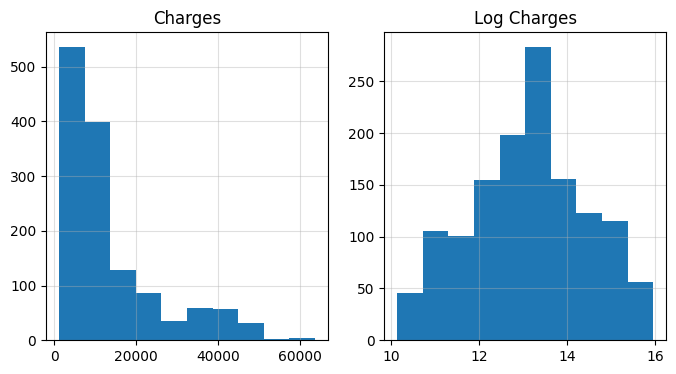

In [2]:
insurance['log_charges'] = np.log2(insurance['charges'])

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(insurance['charges'])
ax1.set_title('Charges')
ax1.grid(alpha=0.4)

ax2.hist(insurance['log_charges'])
ax2.set_title('Log Charges')
ax2.grid(alpha=0.4)

plt.show()

The histogram of the target is very skewed, probably due to large differences in values. The logarithmic charges look better and are closer to a Gaussian distribution.

In [3]:
insurance.dtypes.value_counts()

object     3
float64    3
int64      2
Name: count, dtype: int64

The dataset has 3 categorical columns and 4 continuous. Let's check correlation with our target.

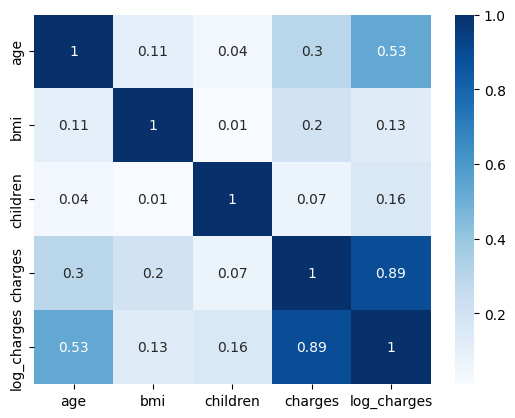

In [4]:
corr = insurance.drop(['sex','smoker','region'], axis=1).corr()
sns.heatmap(round(corr,2), annot=True, cmap='Blues')
plt.show()

As we see above correlations between continuos features and our target aren't very strong, but we can highlight the `age` and `bmi` columns (respectively 0.3 and 0.2).

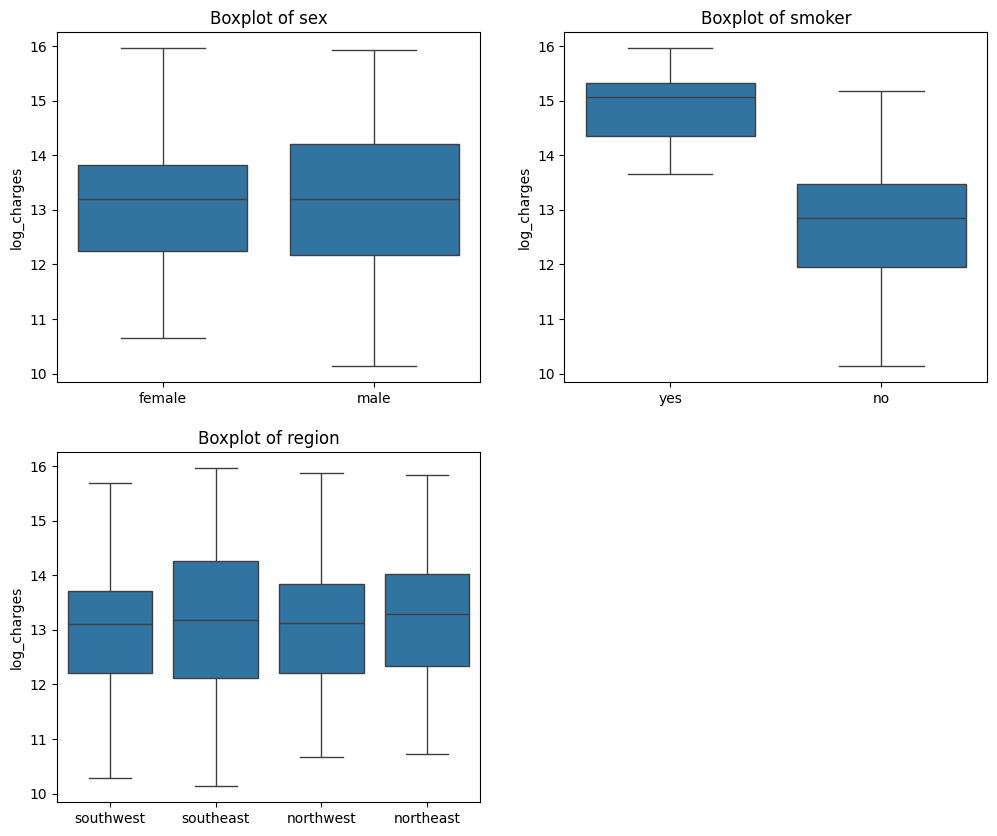

In [5]:
cat_cols = ['sex','smoker','region']

fig = plt.figure(figsize=(12,10))

for n, col in enumerate(cat_cols):
    ax = fig.add_subplot(2,2, n+1)
    sns.boxplot(data=insurance, y='log_charges', x=col)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel('')

plt.show()

Boxplots shows us:
* males has wider distribution of charges,
* smokers has higher charges,
* the region hasn't strong impact and in every region charges are similar.

Summarise the exploration of the dataset we can choose to the model following features:
* `age`;
* `bmi`;
* `smoker`.

# Dividing The Data

In [6]:
insurance['smoker_01'] = insurance['smoker']
insurance['smoker_01'] = insurance['smoker_01'].apply(lambda x: 1 if x == 'yes' else 0)

In [7]:
insurance_subset = insurance[['age','bmi','smoker_01']]
target = insurance['log_charges']

X_train, X_test, y_train, y_test = train_test_split(insurance_subset, target, test_size = 0.2, random_state=123)

# Build The Model

After dviding up the data into traing and test set, I'm ready to build predictive linear model.

In [8]:
lm = LinearRegression()
lm.fit(X_train, y_train)

intercept = lm.intercept_
coefficients = lm.coef_

In [9]:
train_predictions = lm.predict(X_train)

train_R2 = r2_score(y_train, train_predictions)
train_mse = np.exp(mean_squared_error(y_train, train_predictions))

print(f'R2: {train_R2}' , f'MSE: {train_mse}', sep='\n')

R2: 0.733335711499113
MSE: 1.6107527287406154


The training MSE for the model is 1.61 on the original scale. The $R^2$ indicates that the model can explain ~74% of the variation in the log-insurance charges. These preliminary results are promising, but we must remember that these are optimistic values.

# Residual Diagnostics

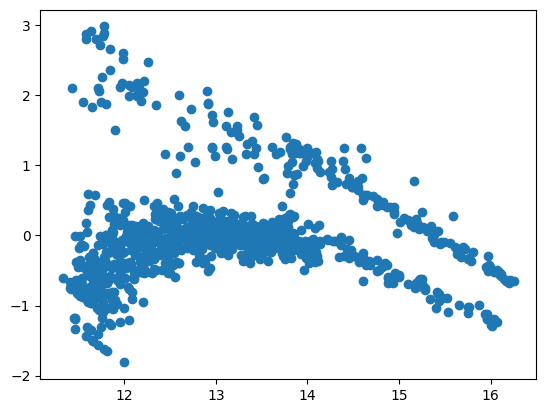

In [10]:
residuals = y_train - train_predictions
plt.scatter(x = train_predictions, y = residuals)
plt.show()

The scatter plots shows us interesting anomaly, because we see patern which shouldn't be. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

# Interpreting The Model

In [11]:
print(f'Intercept: {intercept}', f'Coefficients: {coefficients}', sep = '\n')

Intercept: 10.125576581760257
Coefficients: [0.05107125 0.0179072  2.19488187]


The linear model can be presented as following equation:

$log\_charges = 10.1256 + 0.0511 \cdot age + 0.0179 \cdot bmi + 2.1959 \cdot smoker\_01$

That means older people with higher BMI which smoke have higher charges. If we want to be more detailed, it means:
* as age increases by 1, the charges increases by 0.0511;
* as BMI increases by 1, the charges increases by 0.0179;
* if you smoke, the charges increases by 2.1959

I have note that, right know I don't know if this coefficients are *statisically significant*. For this project I building only the prediction linear model.

# Model Evaluation

The training error is almost always very optimistic, so I can't use it as the final opinion of the model's predicitve ability. It's time to see how the model performs on the test data, which model doesn't see.

In [12]:
test_pred = lm.predict(X_test)

test_R2 = r2_score(y_test, test_pred)
test_mse = np.exp(mean_squared_error(y_test, test_pred))

print(f'R2: {test_R2}' , f'MSE: {test_mse}', sep='\n')

R2: 0.7915300066869189
MSE: 1.406957115630544


As we see above the model explain 79% of data which is bette result than for training set. Moreover MSE drop down to 1.41 on the original scale. It means that our model has good performance and is not overfit.

Apart from that residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. Therefore the model struggles with these higher costs. As a whole, the model predictions are too conservative.

To have better model I should consider the transformation of features and take a closer look at interactions.